In [109]:
import pathml
from pathml import HESlide
import matplotlib.pyplot as plt
import numpy as np
from pathml.core import HESlide

%matplotlib inline

# Load image

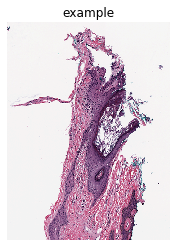

In [109]:
wsi = HESlide("tests/testdata/small_HE.svs", name = "example")
wsi.plot()

In [110]:
wsi #svs

SlideData(name='example',
	slide_type=SlideType(stain=HE, platform=None, tma=None, rgb=True, volumetric=None, time_series=None),
	filepath='tests/testdata/small_HE.svs',
	backend='openslide',
	image shape: (2967, 2220),
	0 tiles: [],
	0 masks: [],
	labels=None,
	counts=None)

# Obtain tiles

In [22]:
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

pipeline = Pipeline([
    BoxBlur(kernel_size=15),
    TissueDetectionHE(mask_name = "tissue", min_region_size=500,
                      threshold=30, outer_contours_only=True)
])

In [111]:
%%time
wsi.run(pipeline, distributed=False,tile_size = 64)
# extract tiles, do not move this line of code above

CPU times: user 2min 27s, sys: 8.82 s, total: 2min 36s
Wall time: 2min 38s


In [112]:
wsi.tiles

1564 tiles: ['(0, 0)', '(0, 1024)', '(0, 1088)', '(0, 1152)', '(0, 1216)', '(0, 128)', ...]

# Extracting features Model 1
## Normal imagenet-trained models

In [7]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import timm

In [113]:
# model 
m = timm.create_model('xception41', pretrained=True,num_classes = 0)

In [115]:
test1 = torch.tensor(wsi.tiles[1].image.transpose([2,1,0]))

test1 = test1.unsqueeze(0)


test1 = test1.float() 

test1.shape
m(test1)

tensor([[0.3077, 0.0000, 0.2693,  ..., 0.0286, 0.0000, 0.2292]],
       grad_fn=<ViewBackward>)

In [116]:
# make a function

# global variable: m (resnet model)
def get_features(t):
    """t: single tile in SlideData object, eg wsi.tiles[0] """
    # transpose to 3,32,32, then tensor, 
    test = torch.tensor(t.image.transpose([2,1,0]))

    # reshape image to 4D 
    # PyTorch expects a 4-dimensional input, the first dimension being the number of samples
    test = test.unsqueeze(0)

    # transform to float, otherwise there's mistake on double/float
    # shape = 1,3,32,32
    test = test.float() 

    # unpooled features
    o_pooled = m(test)

    # flatten the unpooled vector: 1 X D
    o_pooled_flat = o_pooled.reshape(1,-1).detach().numpy()
    
    return o_pooled_flat



In [117]:
# make a loop
features = []
for ti in wsi.tiles:
    features.append(get_features(ti))
features = np.vstack(np.array(features))

# check shape
features.shape

(1564, 2048)

In [121]:
# store that in a dataframe, for the pca operations later 
import pandas as pd

df = pd.DataFrame(features)
df.to_csv('tilefeatures.csv', index=False) 

# Extracting Features Model 2
## Pathology-trained model

In [2]:
pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchtext

  Using cached torchtext-0.10.1-cp38-cp38-macosx_10_9_x86_64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pytorch-lightning

  Using cached pytorch_lightning-1.4.9-py3-none-any.whl (925 kB)
  Using cached torchmetrics-0.5.1-py3-none-any.whl (282 kB)
  Using cached pyDeprecate-0.3.1-py3-none-any.whl (10 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached aiohttp-3.7.4.post0-cp38-cp38-macosx_10_14_x86_64.whl (648 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-macosx_10_9_x86_64.whl (3.5 MB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
     |████████████████████████████████| 288 kB 3.4 MB/s eta 0:00:01
  Using cached google_auth-1.35.0-py2.py3-none-any.whl (152 kB)
     |████████████████████████████████| 131 kB 52.9 MB/s eta 0:00:01
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 1.0 MB 53.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 34.7 MB/s eta 0:00:01
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (1

In [5]:
import torchvision
import torch

In [6]:
MODEL_PATH = '/Users/jiesun/Dropbox/2021_FALL/DanaFaber/self-supervised-histopathology/tenpercent_resnet18.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


In [9]:
def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model

model = torchvision.models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location=torch.device('cpu'))

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)


if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

# model = model.cuda()

images = torch.rand((10, 3, 224, 224), device='cpu')

out = model(images)

In [10]:
out.shape #features to do pca on

torch.Size([10, 512])

# Under Experiment

In [86]:
from torch.utils.data import Dataset

# for reference, it's a method of the SlideData class
def _create_tile_dataset(slidedata):
    # create a pytorch dataset for tiles, also with slide-level labels
    class TileDataset(Dataset):
        def __init__(self, slidedata):
            if slidedata.tiles is None:
                raise ValueError(
                    "Can't create tile dataset because self.tiles is None"
                )
            self.tiles = slidedata.tiles
            self.labels = slidedata.labels

        def __len__(self):
            return len(self.tiles)

        def __getitem__(self, ix):
           

            return torch.tensor(self.tiles[ix].image, dtype = torch.float32)

    return TileDataset(slidedata) # pytorch tensor

In [87]:
a = _create_tile_dataset(wsi)

In [91]:
from torch.utils.data import DataLoader, Dataset
b = DataLoader(a, batch_size = 1, )